In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
# from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k, ndcg_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [3]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [5]:
recommender = MainRecommender(data_train_lvl_1)

/Users/ibogdanov/Library/Python/3.7/lib/python/site-packages/implicit/utils.py:29: UserWarning: OpenBLAS detected. Its highly recommend to set the environment variable 'export OPENBLAS_NUM_THREADS=1' to disable its internal multithreading
  "OpenBLAS detected. Its highly recommend to set the environment variable "


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [6]:
recommender.get_als_recommendations(2375, N=5)

[1029743, 1106523, 1044078, 844179, 899624]

In [7]:
recommender.get_own_recommendations(2375, N=5)

[1029743, 1106523, 5569230, 916122, 844179]

In [8]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1072086, 819255, 934399, 7104690]

In [9]:
recommender.get_similar_users_recommendation(2375, N=5)

[896862, 5569230, 1044078, 1106523, 899624]

#### Обучим модели первого уровня

In [10]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [11]:
# result_lvl_1['similar_users'] = result_lvl_1['user_id'].\
#     apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

In [12]:
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [13]:
k = [20, 50, 100, 200, 500]
result_metrics_own = []
result_metrics_als = []
result_metrics_sim_items = []
result_metrics_sim_users = []
for i in k:
    result_lvl_1[f'own_{i}'] = result_lvl_1['user_id'].\
        apply(lambda x: recommender.get_own_recommendations(x, N=i))
    
    result_metrics_own.append(result_lvl_1.\
        apply(lambda row: recall_at_k(row[f'own_{i}'], row['actual'], k=i), axis=1).mean())
    
    result_lvl_1[f'als_{i}'] = result_lvl_1['user_id'].\
        apply(lambda x: recommender.get_als_recommendations(x, N=i))
    
    result_metrics_als.append(result_lvl_1.\
        apply(lambda row: recall_at_k(row[f'als_{i}'], row['actual'], k=i), axis=1).mean())
    
    result_lvl_1[f'similar_items_{i}'] = result_lvl_1['user_id'].\
        apply(lambda x: recommender.get_similar_items_recommendation(x, N=i))
    
    result_metrics_sim_items.append(result_lvl_1.\
        apply(lambda row: recall_at_k(row[f'similar_items_{i}'], row['actual'], k=i), axis=1).mean())

In [14]:
result_metrics_own

[0.03030969145410023,
 0.043203153803359796,
 0.06156821408021987,
 0.08940276042445724,
 0.1318168244194137]

In [15]:
result_metrics_als

[0.04025970238590963,
 0.06294311403471096,
 0.08647412384584201,
 0.11484368932618982,
 0.16200324376777755]

In [16]:
result_metrics_sim_items

[0.01665271273900352,
 0.032484583568896726,
 0.05263947775431139,
 0.08785989495335246,
 0.14375150084803814]

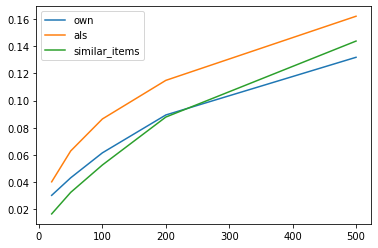

In [17]:
import matplotlib.pyplot as plt

x = k  # X-axis points
y1 = result_metrics_own  # Y-axis points
y2 = result_metrics_als
y3 = result_metrics_sim_items

plt.plot(x, y1)  # Plot the chart
plt.plot(x, y2)
plt.plot(x, y3)

plt.legend(['own', 'als', 'similar_items'])
plt.show()

Модель Als имеет лучшие показатели полноты recall при всех заданных значениях k. В районе k=200 наблюдается перегиб графиков и прирост полноты начинает снижаться. Выберем модель als и k=200 для модели второго уровня.  

#### Обучим модель 2-ого уровня

In [18]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=200))
users_candidates = users_lvl_2.copy()

In [19]:
users_lvl_2.head(2)

,user_id,candidates
0,2070,"[1029743, 844179, 899624, 1044078, 866211, 965..."
1,2021,"[1029743, 1044078, 1106523, 844179, 5569230, 9..."


In [20]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)

users_lvl_2.head(4)

,user_id,item_id
0,2070,1029743
0,2070,844179
0,2070,899624
0,2070,1044078


In [21]:
users_lvl_2.shape[0]

430200

In [22]:
users_lvl_2['user_id'].nunique()

2151

In [23]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)

In [24]:
targets_lvl_2.head(2)

,user_id,item_id,target
0,2070,1029743,0.0
1,2070,844179,0.0


In [25]:
targets_lvl_2.shape

(436957, 3)

In [26]:
targets_lvl_2['target'].mean()

0.05159775447011949

In [27]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [28]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [29]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,844179,0.0,2852,MEAT,National,BEEF,PRIMAL,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [30]:
targets_lvl_2.shape

(436957, 16)

### Создадим новые фичи

1. Фичи user_id: 
    - Средний чек (avg_basket_value)
    - Кол-во покупок в каждой категории (items_per_cat_count)

In [31]:
# Средний чек
avg_basket_value = data_train_lvl_2.groupby(['user_id', 'basket_id'])['sales_value'].sum().groupby('user_id').mean()
avg_basket_value

user_id
1       48.825714
2       47.572500
4       39.796667
6       20.562500
7       37.530000
          ...    
2496    69.372000
2497    31.147222
2498    14.180000
2499    30.782500
2500    41.700000
Name: sales_value, Length: 2154, dtype: float64

In [32]:
targets_lvl_2 = targets_lvl_2.merge(avg_basket_value, on='user_id', how='left')
targets_lvl_2.rename(columns={'sales_value': 'avg_basket_value'}, inplace=True)
targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,avg_basket_value
0,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581
1,2070,844179,0.0,2852,MEAT,National,BEEF,PRIMAL,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581


In [33]:
targets_lvl_2.shape

(436957, 17)

In [34]:
data_train_desc = data_train_lvl_2.merge(item_features, on='item_id', how='left')
data_train_desc.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0,1232,GROCERY,National,SOFT DRINKS,SOFT DRINK BOTTLE NON-CARB (EX,20 OZ
1,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0,69,GROCERY,Private,EGGS,EGGS - LARGE,1 DZ


In [35]:
# Количество покупок в каждой категории
cat_counts = data_train_desc.groupby(['user_id', 'commodity_desc'])['item_id'].count()
cat_counts.rename('items_per_cat_count', inplace=True)
cat_counts

user_id  commodity_desc              
1                                        1
         AIR CARE                        3
         APPLES                          2
         BAG SNACKS                      1
         BAKED BREAD/BUNS/ROLLS          9
                                        ..
2500     SOFT DRINKS                     4
         STATIONERY & SCHOOL SUPPLIES    2
         TROPICAL FRUIT                  2
         VEGETABLES - SHELF STABLE       1
         YOGURT                          6
Name: items_per_cat_count, Length: 75950, dtype: int64

In [36]:
targets_lvl_2 = targets_lvl_2.merge(cat_counts, on=['user_id', 'commodity_desc'], how='left')
targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,avg_basket_value,items_per_cat_count
0,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,3.0
1,2070,844179,0.0,2852,MEAT,National,BEEF,PRIMAL,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,2.0


In [37]:
targets_lvl_2['items_per_cat_count'].fillna(0, inplace=True)

In [38]:
targets_lvl_2.shape

(436957, 18)

2. Фичи item_id: 

    - сумма покупок item_id в категории к общей сумме покупок товаров данной категории (item_sum_per_cat)

In [39]:
item_sum_per_cat = data_train_desc.groupby(['item_id', 'commodity_desc'])['quantity'].sum() / data_train_desc.groupby(['commodity_desc'])['quantity'].sum()
item_sum_per_cat.rename('items_sum_per_cat', inplace=True)
item_sum_per_cat

item_id   commodity_desc          
28116     DRY MIX DESSERTS            0.000979
28117     DRY MIX DESSERTS            0.000979
28143     DRY MIX DESSERTS            0.000979
28186     BAKING MIXES                0.000501
28304     SOUP                        0.000147
                                        ...   
17381856  NO COMMODITY DESCRIPTION    0.000000
17382205  NO COMMODITY DESCRIPTION    0.002404
17383227  BOOKSTORE                   0.006711
17827644  NO COMMODITY DESCRIPTION    0.002404
17829232  CANDY - PACKAGED            0.000595
Name: items_sum_per_cat, Length: 27649, dtype: float64

In [40]:
targets_lvl_2 = targets_lvl_2.merge(item_sum_per_cat, on=['item_id', 'commodity_desc'], how='left')
targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,avg_basket_value,items_per_cat_count,items_sum_per_cat
0,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,3.0,0.163873
1,2070,844179,0.0,2852,MEAT,National,BEEF,PRIMAL,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,2.0,0.081330


In [41]:
targets_lvl_2['items_sum_per_cat'].fillna(0, inplace=True)

In [42]:
targets_lvl_2.shape

(436957, 19)

Выделим целевую переменную target в y_train, удалив при этом из Х_train.

In [43]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [44]:
X_train.fillna('Unknown', inplace=True)

Выделим категориальные признаки для их обработки в CatBoostClassifier.

In [45]:
cat_feats = X_train.columns[2:15].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [46]:
from catboost import CatBoostClassifier


cb = CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True)
cb.fit(X_train, y_train, cat_features=cat_feats)

train_preds = cb.predict(X_train)

In [47]:
train_preds

array([0., 0., 1., ..., 0., 0., 0.])

In [48]:
# Отберем положительные рекомендации:
recs_2 = targets_lvl_2.loc[[p == 1 for p in train_preds]]

In [49]:
recs_2.shape

(7472, 19)

In [50]:
# Сгруппируем по user_id
recs_true = recs_2.groupby('user_id')['item_id'].apply(list).reset_index(name='item_ids')

In [51]:
recs_true.head(5)

,user_id,item_ids
0,1,"[940947, 940947, 940947, 1029743, 1098248, 829..."
1,2,"[1029743, 979707]"
2,6,"[1024306, 1024306, 1024306, 1024306, 1082185, ..."
3,7,"[1029743, 1082185, 1082185]"
4,8,"[1029743, 1029743, 1068719, 872137]"


In [52]:
recs_true.shape

(1198, 2)

In [53]:
# Список купленных каждым пользователем товаров из второй валидацинной выборки
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']
result_lvl_2.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [54]:
result_lvl_2.shape

(2042, 2)

In [55]:
# Соединяем с полученными на выходе второй модели предсказаниями и заполняем список рекомендаций для отсутствующих в recs_true  
# пользователей рекомендациями, полученными для этих пользователей из первой модели.
result_lvl_2 = result_lvl_2.merge(recs_true, on='user_id', how='left')
result_lvl_2.rename(columns={'item_ids': 'recs2'}, inplace=True)
result_lvl_2.loc[result_lvl_2['recs2'].isnull()] = result_lvl_2.loc[result_lvl_2['recs2'].isnull()].apply(lambda x: [])
result_lvl_2 = result_lvl_2[result_lvl_2['user_id'].isin(users_candidates['user_id'])]

In [56]:
result_lvl_2

,user_id,actual,recs2
0,1.0,"[821867, 834484, 856942, 865456, 889248, 90795...","[940947, 940947, 940947, 1029743, 1098248, 829..."
2,6.0,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1024306, 1024306, 1024306, 1024306, 1082185, ..."
3,7.0,"[840386, 889774, 898068, 909714, 929067, 95347...","[1029743, 1082185, 1082185]"
4,8.0,"[835098, 872137, 910439, 924610, 992977, 10412...","[1029743, 1029743, 1068719, 872137]"
5,9.0,"[864335, 990865, 1029743, 9297474, 10457112, 8...","[1029743, 1082185]"
...,...,...,...
2037,2496.0,[6534178],"[916122, 916122]"
2038,2497.0,"[1016709, 9835695, 1132298, 16809501, 845294, ...","[1029743, 1106523, 871756, 1051516]"
2039,2498.0,"[15716530, 834484, 901776, 914190, 958382, 972...","[1029743, 1106523, 1106523]"
2040,2499.0,"[867188, 877580, 902396, 914190, 951590, 95813...",[1068719]


In [57]:
def getCandidates(user_id):
    return users_candidates.loc[users_candidates['user_id'] == user_id, 'candidates'].values[0]

In [58]:
# Дополняем количество рекомендаций до 5-ти
def extend_from_candidates(row):
    if len(row['recs2']) < 5:
        candidates = getCandidates(row['user_id'])
        for candidate in candidates:
            if candidate not in row['recs2']:
                row['recs2'].append(candidate)
            if len(row['recs2']) == 5:
                return row
    else:
        row['recs2'] = row['recs2'][:5]
    return row

In [68]:
result_lvl_2 = result_lvl_2.apply(lambda row: extend_from_candidates(row), axis=1)

In [69]:
result_lvl_2

,user_id,actual,recs2
0,1.0,"[821867, 834484, 856942, 865456, 889248, 90795...","[940947, 940947, 940947, 1029743, 1098248]"
2,6.0,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1024306, 1024306, 1024306, 1024306, 1082185]"
3,7.0,"[840386, 889774, 898068, 909714, 929067, 95347...","[1029743, 1082185, 1082185, 916122, 1126899]"
4,8.0,"[835098, 872137, 910439, 924610, 992977, 10412...","[1029743, 1029743, 1068719, 872137, 5569230]"
5,9.0,"[864335, 990865, 1029743, 9297474, 10457112, 8...","[1029743, 1082185, 1106523, 5569230, 1070820]"
...,...,...,...
2037,2496.0,[6534178],"[916122, 916122, 1044078, 844179, 874972]"
2038,2497.0,"[1016709, 9835695, 1132298, 16809501, 845294, ...","[1029743, 1106523, 871756, 1051516, 5569230]"
2039,2498.0,"[15716530, 834484, 901776, 914190, 958382, 972...","[1029743, 1106523, 1106523, 1070820, 916122]"
2040,2499.0,"[867188, 877580, 902396, 914190, 951590, 95813...","[1068719, 1029743, 1106523, 5569230, 8090521]"


In [70]:
result_lvl_2.apply(lambda row: ndcg_at_k(row['recs2'], row['actual']), axis=1).mean()

0.3347729980669704

In [71]:
result_lvl_2.apply(lambda row: precision_at_k(row['recs2'], row['actual']), axis=1).mean()

0.33368421052631575

In [72]:
result_lvl_2.apply(lambda row: recall_at_k(row['recs2'], row['actual']), axis=1).mean()

0.03021395981795243

In [73]:
result_lvl_1['als_5'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=5))

In [74]:
result_lvl_1.apply(lambda row: precision_at_k(row['als_5'], row['actual']), axis=1).mean()

0.1680594243268338

precision@5 у второй модели вырос вдвое по сравнению с первой.

In [77]:
recommendations = result_lvl_2.drop('actual', axis=1)

In [80]:
recommendations.to_csv('recommendations.csv', index=False)